# Density vs density-contrast

## import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

# local python scripts
from RIS_gravity_inversion import plotting, synthetic
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils


from antarctic_plots import utils, regions, maps, fetch, profile
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import harmonica as hm
import pygmt

Here we show that the calculated forward gravity across a single density contrast (below Fig. a) can be modelled in three ways:
1) Fig. b) as 2 prism layers with absolute densities.
2) Fig. c-d) as 1 prism layer with density relative to the material on the other side of the contrast, or 
3) Fig. e) with prisms of positive or negative density contrast, depending on their position relative to a reference level.
<img src="../figures/absolute_vs_density_contrasts_1surface.svg" width="1000"/>

## Get sample data

Bed from Bedmap2

In [2]:
spacing = 1e3

inner_region = [-20e3, 20e3, -20e3, 20e3]

buffer_region = utils.alter_region(inner_region, buffer=40e3)[1]

bed = fetch.bedmap2(
    layer="bed",
    region=buffer_region,
    spacing=spacing,
)

# fig = maps.plot_grd(
#     bed,
#     inset=True,
#     titles="Bed",
#     cbar_label="elevation (m)",
#     # show_region=inner_region,
#     hist=True,
# )

# fig.show()

utils.get_grid_info(bed)

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


returning grid with new region and/or registration, same spacing


(1000.0, [-60000.0, 60000.0, -60000.0, 60000.0], -477.0, 729.0, 'g')

## create observation points

In [3]:
coords = vd.grid_coordinates(
    inner_region,
    spacing=spacing * 2,
    extra_coords=3e3,
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="z",
    dims=("y", "x"),
).z

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

observation_points = vd.grid_to_table(observations)

(2000.0, [-20000.0, 20000.0, -20000.0, 20000.0], 3000.0, 3000.0, 'g')


## Absolute Densities

In [4]:
ice_prisms = inv_utils.grids_to_prisms(
    bed,
    bed.values.max(),
    density=917,
)

bed_prisms = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670,
)

plotting.show_prism_layers(
    [ice_prisms, bed_prisms],
    cmap="viridis",
    # color_by="density",
    # color_by="thickness",
    color_by="constant",
    clip_box=False,
    zscale=20,
    # backend='client',
)

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/plotting/plotting.py:147: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


Widget(value="<iframe src='http://localhost:43983/index.html?ui=P_0x7fbd3d328ee0_0&reconnect=auto' style='widt…

  0%|          | 0/441 [00:00<?, ?it/s]

  0%|          | 0/441 [00:00<?, ?it/s]

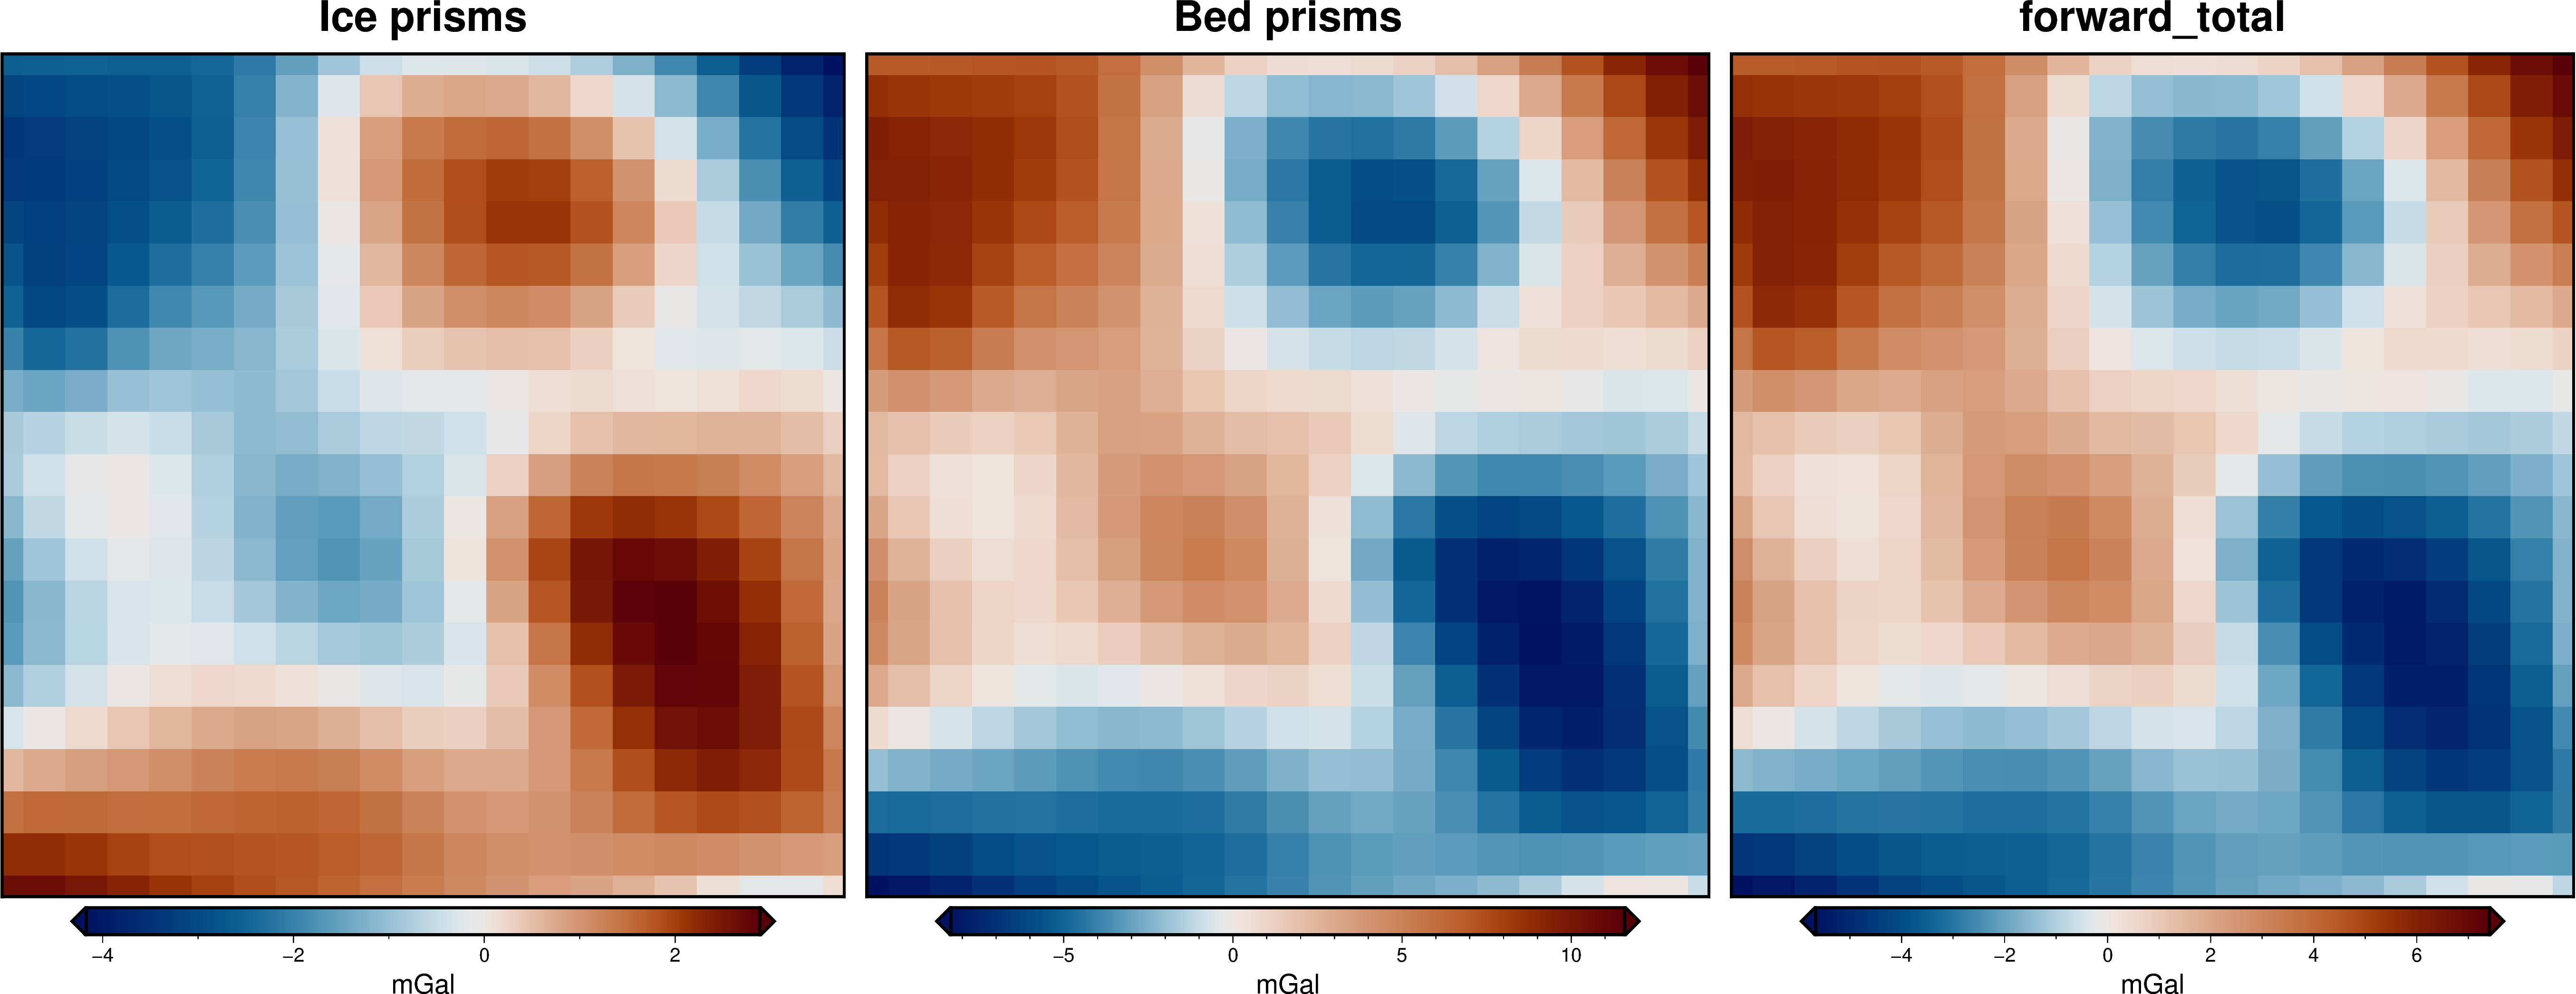

In [5]:
forward_absolute, df = inv_utils.forward_grav_of_prismlayer(
    [ice_prisms, bed_prisms],
    observation_points,
    plot=True,
    names=["Ice prisms", "Bed prisms"],
    remove_mean=True,
    progressbar=True,
)

## Above/below reference

In [6]:
density_contrast = 2670 - 917
grid = bed

zref = grid.values.mean()
density = xr.where(grid >= zref, density_contrast, -density_contrast)

zref_prisms = inv_utils.grids_to_prisms(
    grid,
    zref,
    density=density,
)

plotting.show_prism_layers(
    [zref_prisms],
    cmap="viridis",
    color_by="density",
    # color_by="thickness",
    # color_by='constant',
    # log_scale=False,
    clip_box=False,
    zscale=20,
)

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/plotting/plotting.py:147: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


Widget(value="<iframe src='http://localhost:43983/index.html?ui=P_0x7fbd3d328280_0&reconnect=auto' style='widt…

  0%|          | 0/441 [00:00<?, ?it/s]

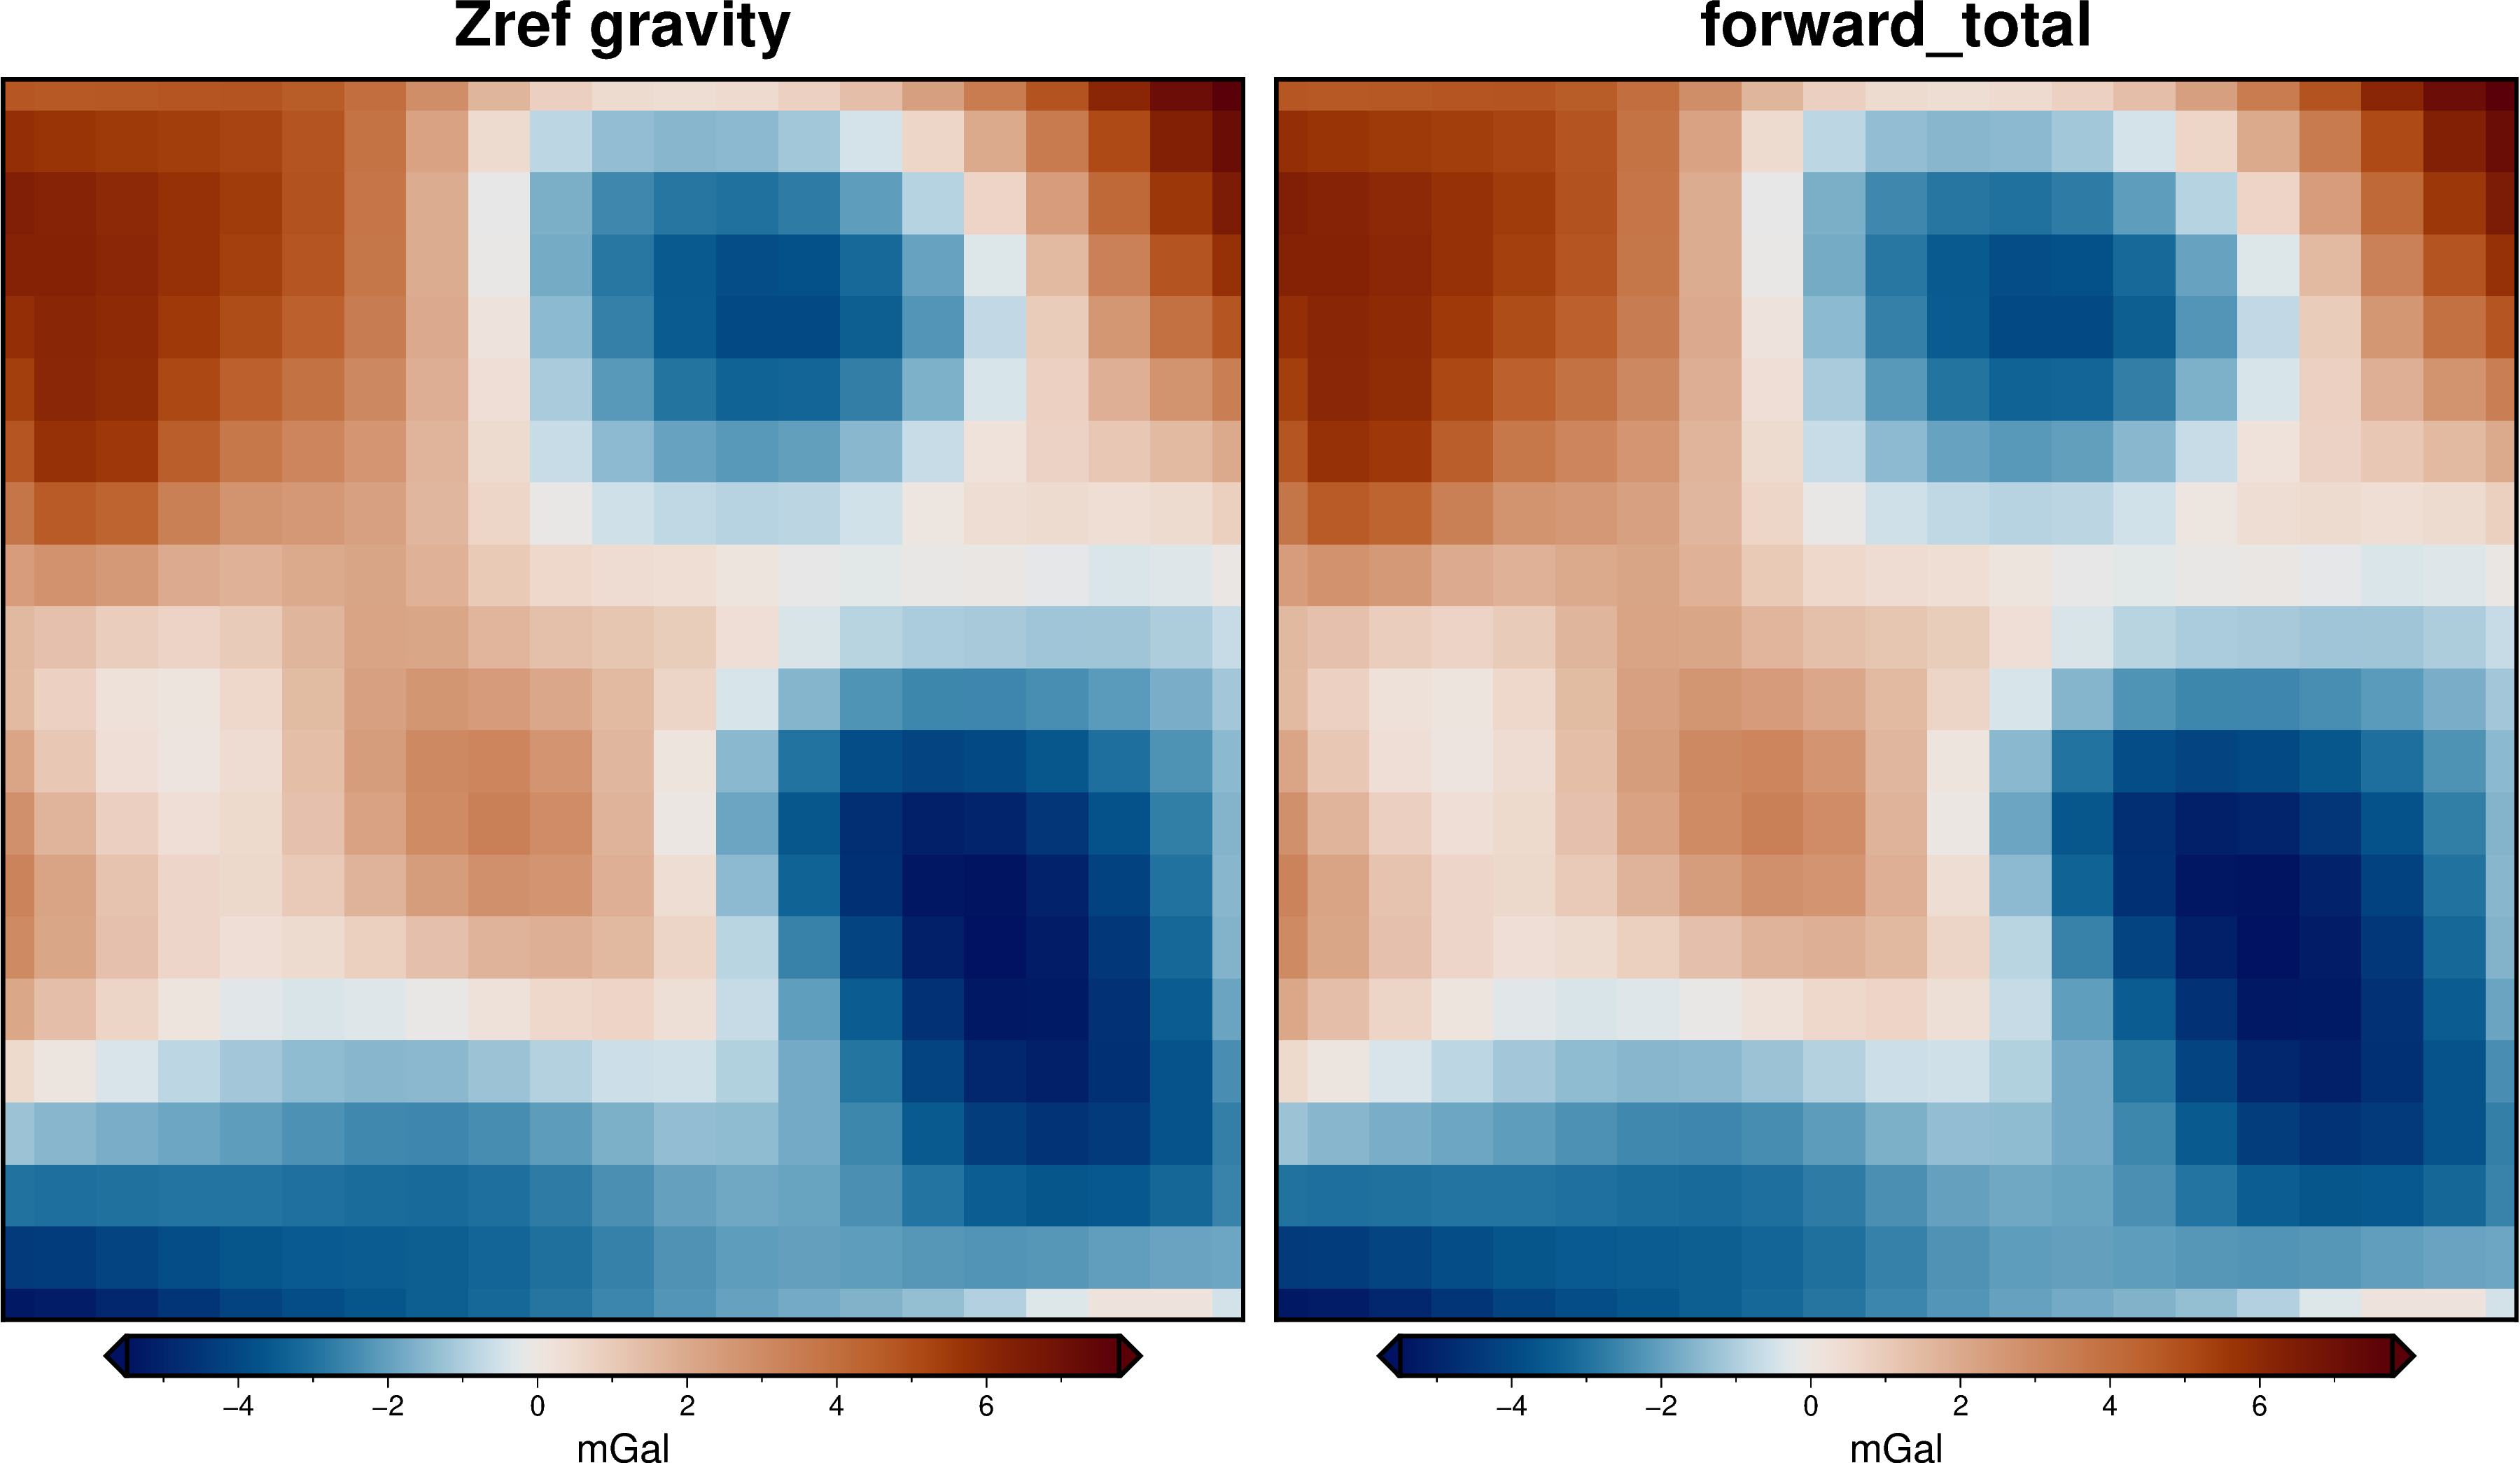

In [7]:
zref_grav, df = inv_utils.forward_grav_of_prismlayer(
    [zref_prisms],
    observation_points,
    plot=True,
    names=["Zref gravity"],
    remove_mean=True,
    progressbar=True,
)

## Density contrasts

In [8]:
prisms_relative_to_ice = inv_utils.grids_to_prisms(
    bed,
    bed.values.min(),
    density=2670 - 917,
)

plotting.show_prism_layers(
    [prisms_relative_to_ice],
    cmap="viridis",
    # color_by="density",
    # color_by="thickness",
    color_by="constant",
    # log_scale=False,
    clip_box=False,
    zscale=20,
)

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/plotting/plotting.py:147: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


Widget(value="<iframe src='http://localhost:43983/index.html?ui=P_0x7fbd67788460_0&reconnect=auto' style='widt…

  0%|          | 0/441 [00:00<?, ?it/s]

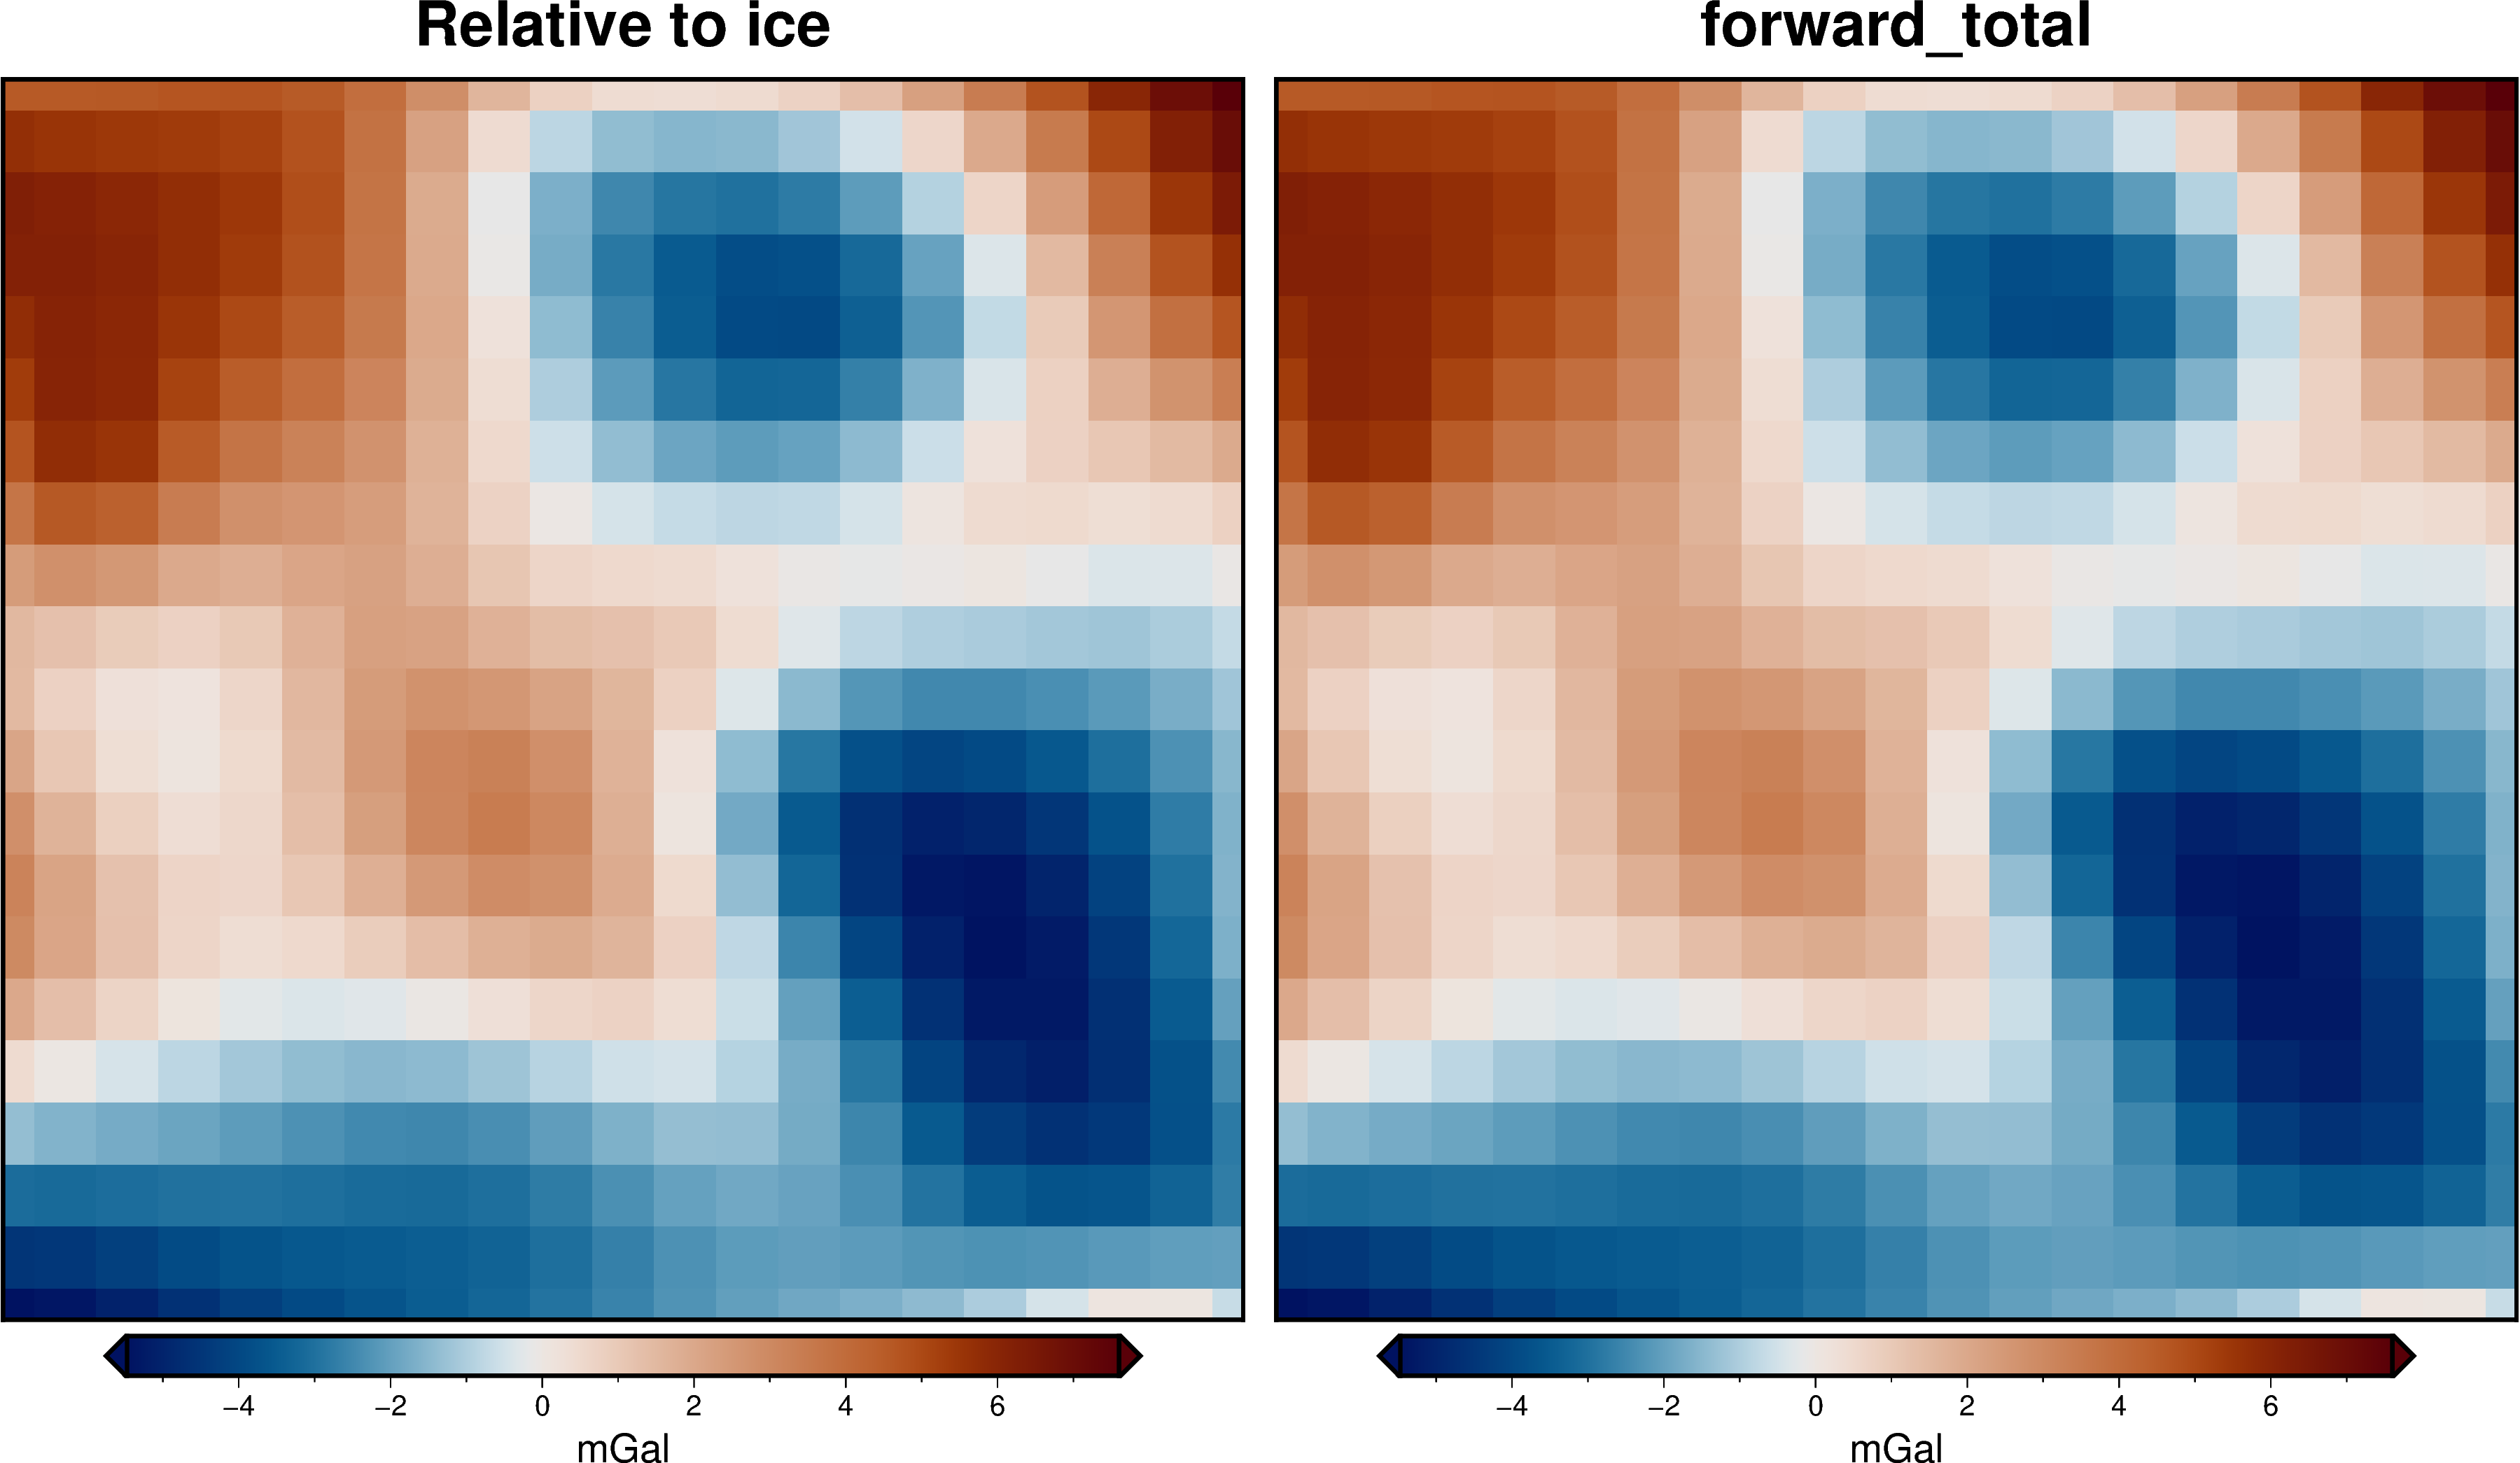

In [9]:
grav_relative_to_ice, df = inv_utils.forward_grav_of_prismlayer(
    [prisms_relative_to_ice],
    observation_points,
    plot=True,
    names=["Relative to ice"],
    remove_mean=True,
    progressbar=True,
)

In [10]:
prisms_relative_to_rock = inv_utils.grids_to_prisms(
    bed,
    bed.values.max(),
    density=917 - 2670,
)

plotting.show_prism_layers(
    [prisms_relative_to_rock],
    cmap="viridis",
    # color_by="density",
    # color_by="thickness",
    color_by="constant",
    # log_scale=False,
    clip_box=False,
    zscale=20,
)

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/pyvista/plotting/plotting.py:147: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


Widget(value="<iframe src='http://localhost:43983/index.html?ui=P_0x7fbc120eb580_0&reconnect=auto' style='widt…

  0%|          | 0/441 [00:00<?, ?it/s]

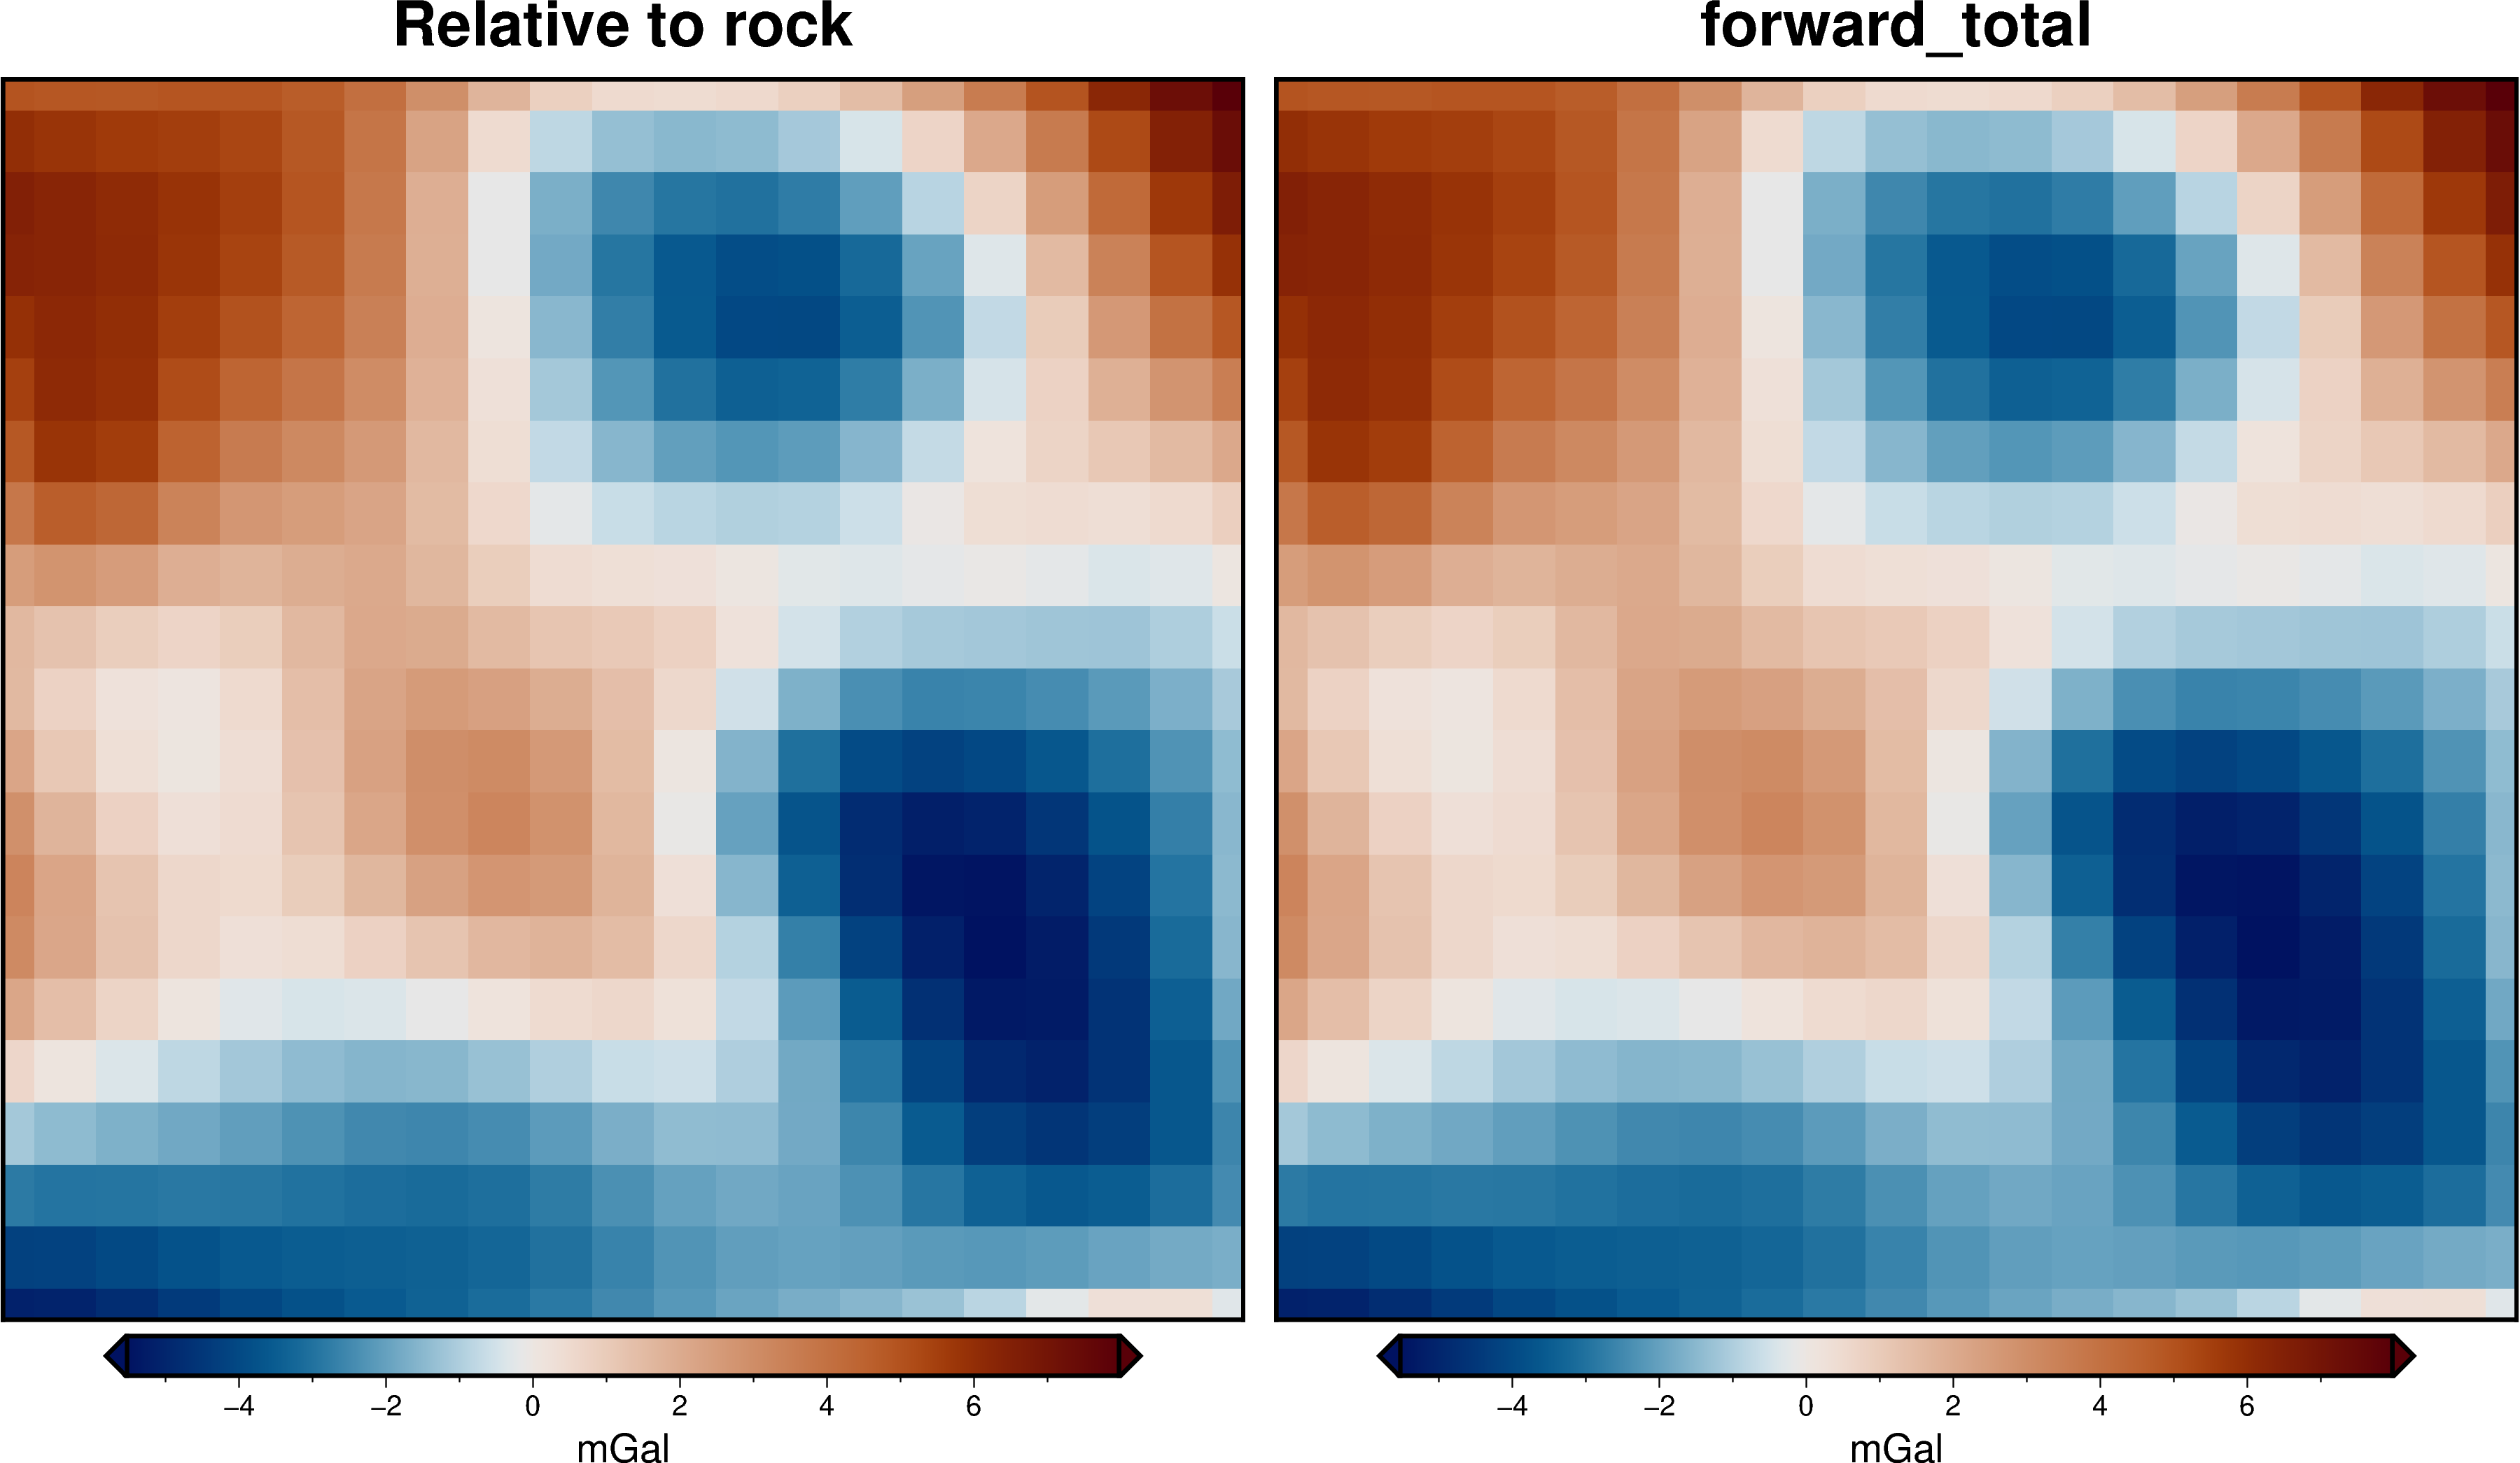

In [11]:
grav_relative_to_rock, df = inv_utils.forward_grav_of_prismlayer(
    [prisms_relative_to_rock],
    observation_points,
    plot=True,
    names=["Relative to rock"],
    remove_mean=True,
    progressbar=True,
)

## Compare forward gravities

In [12]:
plot_type = "xarray"
# plot_type = 'pygmt'

returning original grid
returning original grid


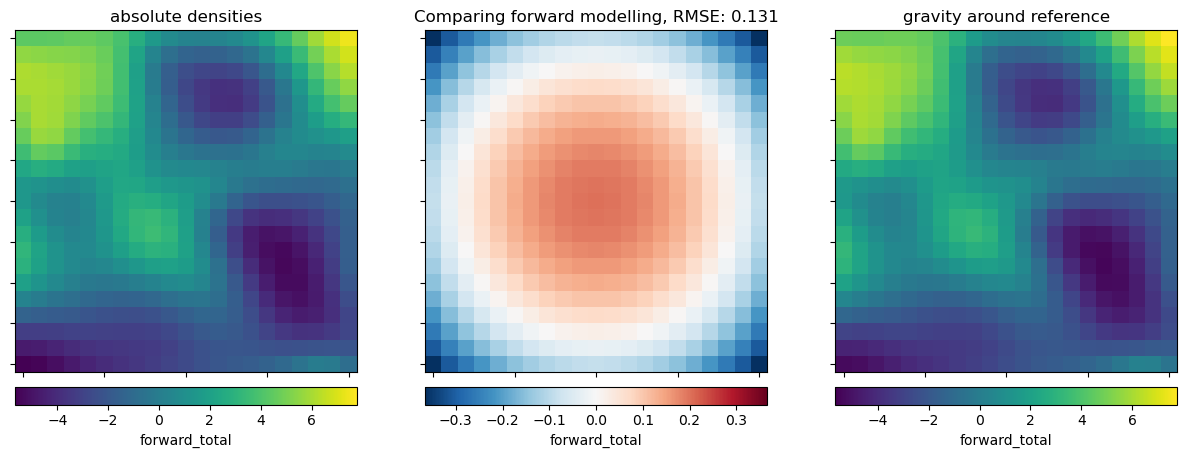

In [13]:
grids = utils.grd_compare(
    forward_absolute.forward_total,
    zref_grav.forward_total,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="gravity around reference",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)

returning original grid
returning original grid


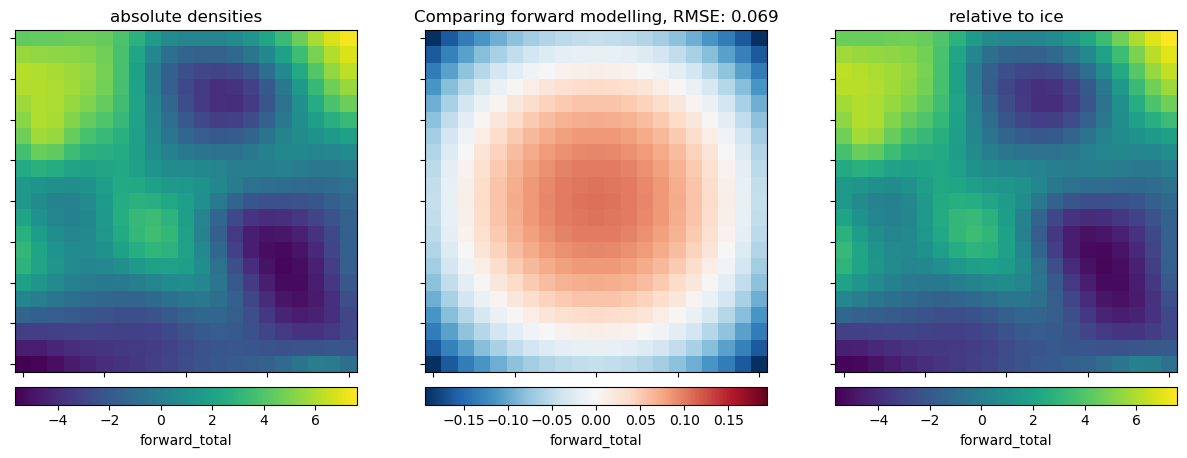

In [14]:
grids = utils.grd_compare(
    forward_absolute.forward_total,
    grav_relative_to_ice.forward_total,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="relative to ice",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)

returning original grid
returning original grid


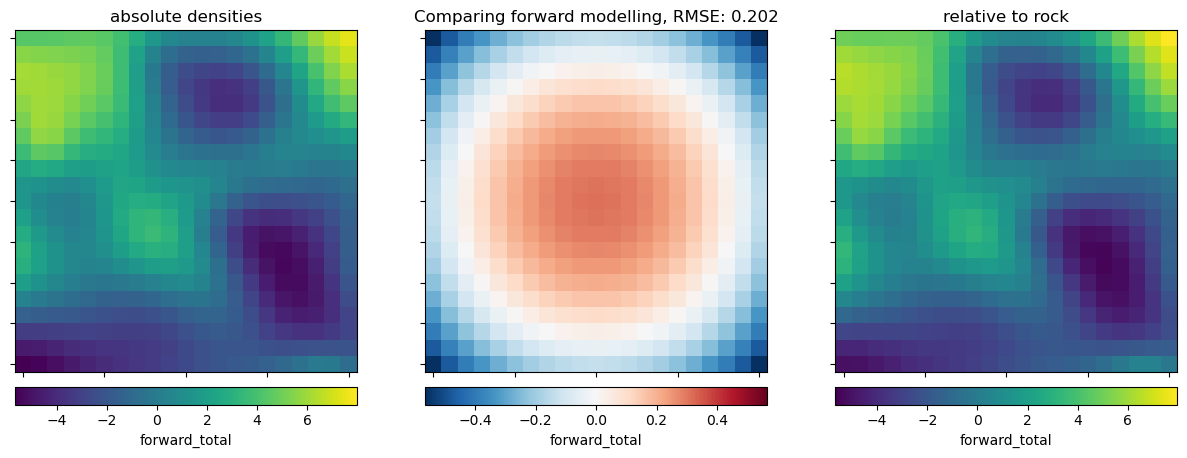

In [15]:
grids = utils.grd_compare(
    forward_absolute.forward_total,
    grav_relative_to_rock.forward_total,
    plot=True,
    grid1_name="absolute densities",
    grid2_name="relative to rock",
    title="Comparing forward modelling",
    # diff_maxabs=50,
    hist=True,
    plot_type=plot_type,
)